<a href="https://colab.research.google.com/github/roguxivlo/machine-learning-24L/blob/main/hw12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Is a *queen* really just a *king*, minus a *man*, plus a *woman*?**

--------------



In class, we dealt with **embeddings** trained for **sentiment classification**. These embeddings are optimized to separate *positive* from *negative* expressions and **do not encode deeper semantic information**.

However, in modern natural language processing, there exist other embeddings — such as those from **BERT**, **word2vec**, or **GloVe** — that **do capture semantic structure**. These models are trained on large corpora, and their embeddings often allow for meaningful **vector arithmetic**, like the famous:

```
embedding("king") - embedding("man") + embedding("woman") ≈ embedding("queen")
```

This homework explores **semantic vector relationships** using such pretrained embeddings.

## **The Objective**

Your task is to:

1. Construct semantic classes of word pairs.
2. Visualize them using PCA.
3. Explore arithmetic operations in embedding space.

## **Tasks & Deliverables**

### 1. **Semantic Pair Classes**

- You must gather **at least 10 classes** of semantically related word pairs.
- Each class must contain **at least 5 pairs**.
- That gives a **minimum total of 100 unique words** (10 classes x 5 pairs x 2 words per pair).

Two example classes:

**Class 1: Gender**

- (king, queen)
- (man, woman)
- (doctor, nurse)
- (prince, princess)
- *(you must add one more)*

**Class 2: Verb tense (past tense)**

- (bring, brought)
- (get, got)
- (like, liked)
- *(you must add two more)*

**Your job:**

- Invent or search for **at least 10 such classes**, including the examples above.
- Each class must be conceptually coherent.
- Other examples: singular/plural, country/capital, comparative/superlative, tool/user, job/object, etc.

### 2. **Global PCA (Across All Words)**

- Use PCA to reduce the **entire set of 100 word embeddings** to 2D, and plot it.
- Plot the additional **10 separate charts**, one for each class.
  - Each chart should display only the 10 words (5 pairs) of the given class.
- Points should be labeled with the words themselves.

### 3. **Local PCA (Per Class)**

- For each class (10 total), perform PCA **only** on the 10 words of that class.
- Plot these class-wise PCA visualizations as separate charts.
- Again, points should be labeled with the words.

**Total: 21 charts**
(1 global plot with 100 words + 10 global-space class plots + 10 local PCA class plots)

Charts should be presented in a self-explanatory manner with clear labels.

### 4. **Embedding Arithmetic**

For each class, choose **one example pair** (e.g., (king, queen)) and perform the operation:

```
embedding(B) - embedding(A) + embedding(C)
```

Where A and B form a known pair, and C is another base word.
For example:

```
embedding("king") - embedding("man") + embedding("woman")
```

* For each such result vector, find the **5 closest word embeddings** (using cosine similarity or Euclidean distance).
* Print the top 5 neighbors **with their distances**.
* Do this **once per class** (i.e., 10 times).

This will make it possible to verify if
 ```
embedding("queen") ≈ embedding("king") - embedding("man") + embedding("woman")
```
for the *gender*-related class.


### 5. **Discussion**

* Analyze and interpret your 21 plots.
* Discuss whether the vector relationships are preserved.
* Does PCA capture semantic differences?
* Are the closest words from the arithmetic meaningful?
* What kinds of relationships are captured, and what are not?
* Are some classes better behaved than others?


### 6. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.


## Acknowledgments

*This homework assignment was inspired by an idea from my master's student **Andrzej Małek**, to whom I would like to express my thanks.*



# 1. Semantic pair classes

In [1]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

semantic_classes = {
    "Gender": [
        ("king", "queen"),
        ("man", "woman"),
        ("doctor", "nurse"),
        ("prince", "princess"),
        ("actor", "actress"),
    ],
    "Verb Tense (Past)": [
        ("bring", "brought"),
        ("get", "got"),
        ("like", "liked"),
        ("go", "went"),
        ("eat", "ate"),
    ],
    "Singular-Plural": [
        ("cat", "cats"),
        ("dog", "dogs"),
        ("house", "houses"),
        ("car", "cars"),
        ("book", "books"),
    ],
    "Country-Capital": [
        ("france", "paris"),
        ("germany", "berlin"),
        ("italy", "rome"),
        ("japan", "tokyo"),
        ("spain", "madrid"),
    ],
    "Comparative-Superlative": [
        ("good", "best"), # Irregular
        ("bad", "worst"), # Irregular
        ("fast", "fastest"),
        ("tall", "tallest"),
        ("happy", "happiest"),
    ],
    "Tool-User/Profession": [
        ("hammer", "carpenter"),
        ("microphone", "singer"),
        ("scalpel", "surgeon"),
        ("microscope", "scientist"),
        ("paint", "painter"),
    ],
    "Object-Property": [
        ("lemon", "sour"),
        ("sugar", "sweet"),
        ("fire", "hot"),
        ("ice", "cold"),
        ("sun", "bright"),
    ],
    "Animal-Habitat": [
        ("lion", "savanna"),
        ("fish", "water"),
        ("bird", "sky"),
        ("bear", "forest"),
        ("whale", "ocean"),
    ],
    "Part-Whole": [
        ("toe", "foot"),
        ("petal", "flower"),
        ("leaf", "plant"),
        ("engine", "plane"),
        ("branch", "tree"),
    ],
    "Antonyms": [
        ("love", "hate"),
        ("big", "small"),
        ("up", "down"),
        ("open", "close"),
        ("day", "night"),
    ],
}

# Verify no duplicates:

words = set()

for semantic_class, pairs in semantic_classes.items():
    for (a,b) in pairs:
        if a in words:
            print(a)
        if b in words:
            print(b)
        words.add(a)
        words.add(b)

print(f"Total: {len(words)} words")


Total: 100 words


# 2. Global PCA

For this point we need to actually download an embedding model

In [2]:
!pip install gensim

In [4]:
import gensim.downloader as api # For easily loading pre-trained word embeddings

print("Downloading GloVe 100-dimensional embeddings (this may take a few minutes)...")
try:
    embedding_model = api.load("glove-wiki-gigaword-100") # You can try "word2vec-google-news-300" for larger size
    print("Embeddings loaded successfully!")
except Exception as e:
    print(f"Error loading embeddings: {e}")
    print("Falling back to dummy embeddings. Please ensure you have an active internet connection or try a different model.")
    embedding_model = None # Fallback


[==================================================] 100.0% 128.1/128.1MB downloaded
Embeddings loaded successfully!


In [5]:
def get_embedding(word, model):
    """
    Retrieves the embedding vector for a given word using the loaded model.
    Handles multi-word expressions for comparative/superlative as well.
    """
    word_lower = word.lower()
    try:
        return model[word_lower]
    except KeyError:
        print(f"Warning: Word '{word}' not found in embedding model. Using dummy vector.")
        return np.random.rand(model.vector_size if model else 100) # Ensure dimension consistency


In [7]:
# --- 2. Global PCA (Across All Words) ---

all_words = []
word_embeddings = []
word_to_class_map = {}

# Gather all unique words and their embeddings
for class_name, pairs in semantic_classes.items():
    for word1, word2 in pairs:
        if word1 not in all_words:
            all_words.append(word1)
            word_embeddings.append(get_embedding(word1, embedding_model))
            word_to_class_map[word1] = class_name
        if word2 not in all_words:
            all_words.append(word2)
            word_embeddings.append(get_embedding(word2, embedding_model))
            word_to_class_map[word2] = class_name



# Convert list of embeddings to a numpy array
word_embeddings_array = np.array(word_embeddings)

# Perform PCA to reduce to 2 dimensions
pca_global = PCA(n_components=2)
transformed_embeddings_global = pca_global.fit_transform(word_embeddings_array)

print(f"\nTotal words for global PCA: {len(all_words)}")
print(f"Shape of global transformed embeddings: {transformed_embeddings_global.shape}")



Total words for global PCA: 100
Shape of global transformed embeddings: (100, 2)


In [8]:
# --- Plotting Function Helper ---
def plot_pca_embeddings(ax, transformed_coords, words_to_plot, title, color_map=None):
    ax.clear() # Clear previous plot if re-using axes
    for i, word in enumerate(words_to_plot):
        x, y = transformed_coords[i, 0], transformed_coords[i, 1]
        if color_map and word in color_map:
            ax.scatter(x, y, color=color_map[word], s=50) # Use a consistent color mapping
        else:
            ax.scatter(x, y, s=50) # Default scatter if no color map
        ax.annotate(word, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.grid(True, linestyle='--', alpha=0.6)
    # Optional: adjust limits to prevent labels from being cut off
    ax.autoscale_view(True, True, True)

/tmp/ipython-input-9-2623196091.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(semantic_classes))


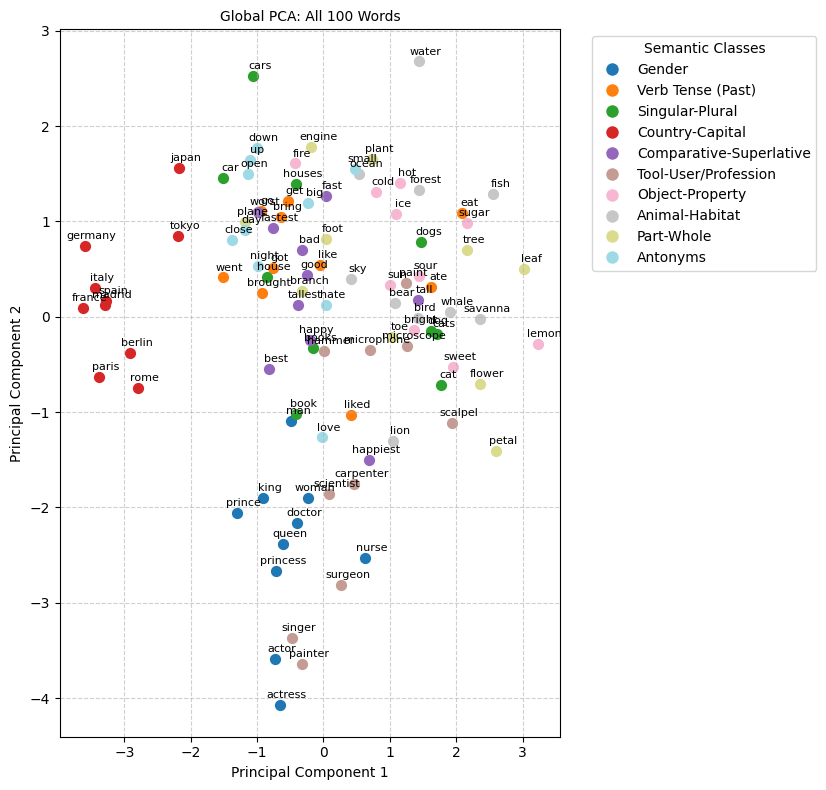


Plotting Global-Space PCA for each class...


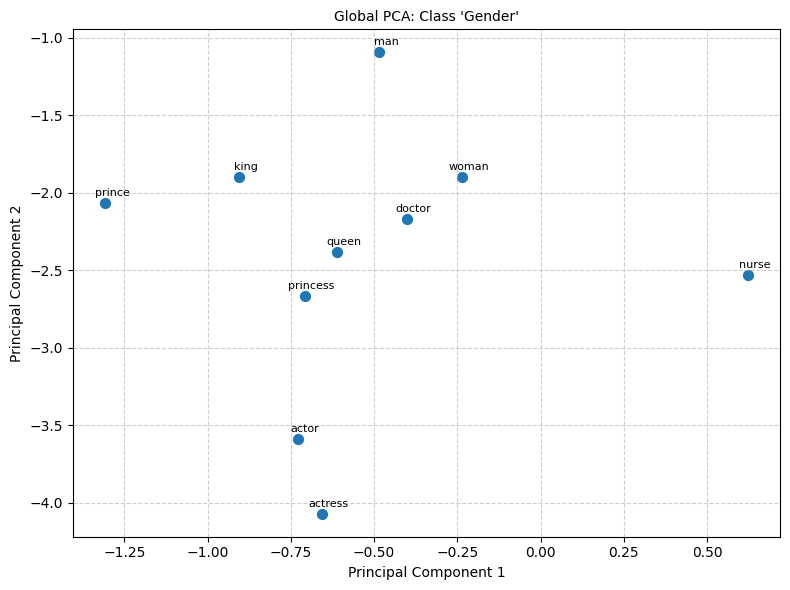

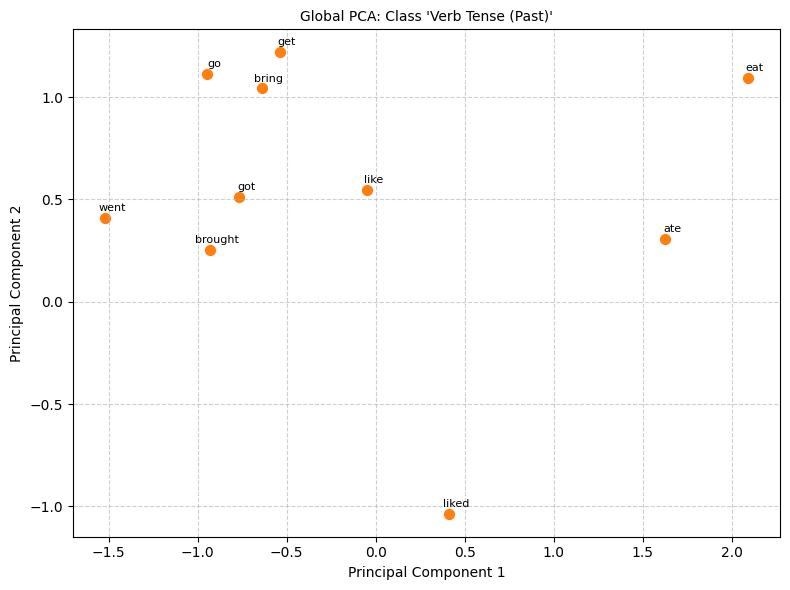

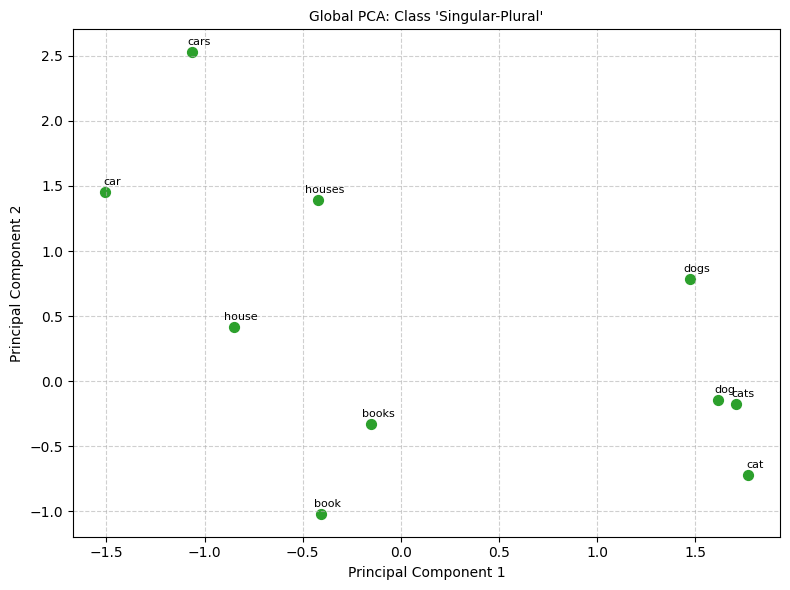

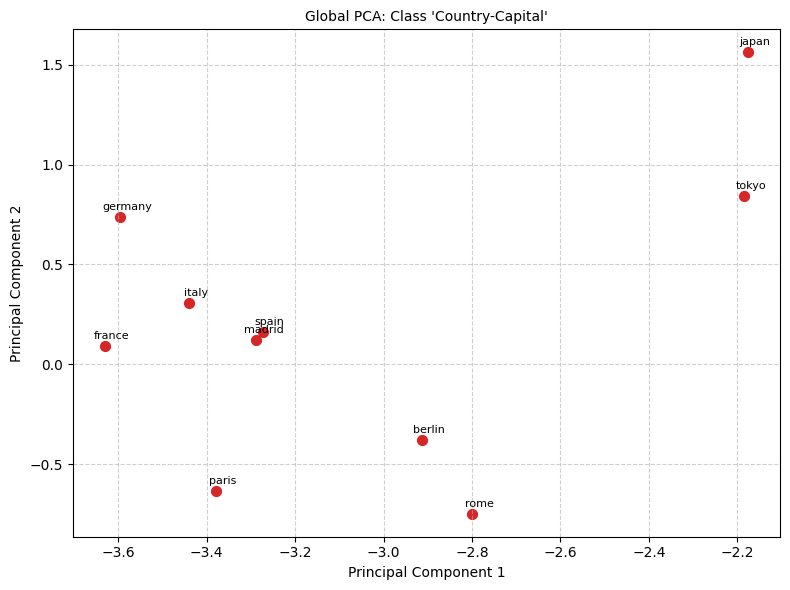

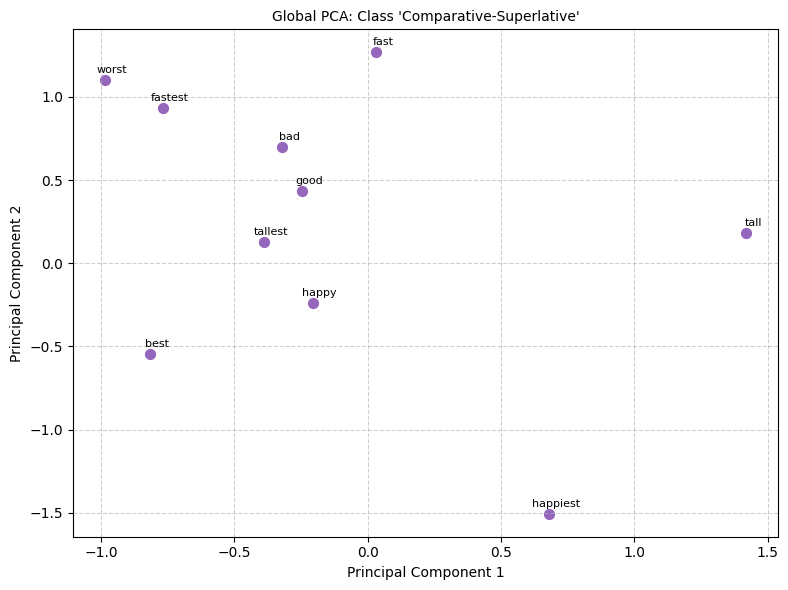

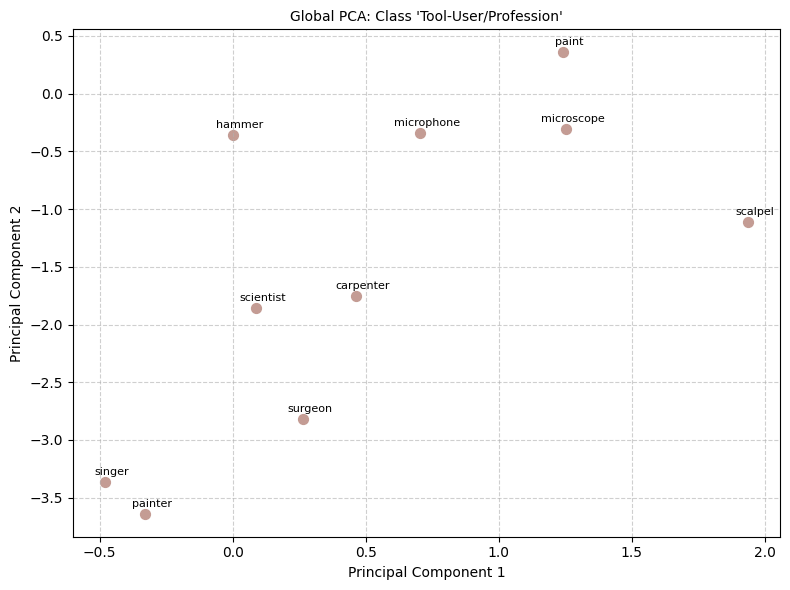

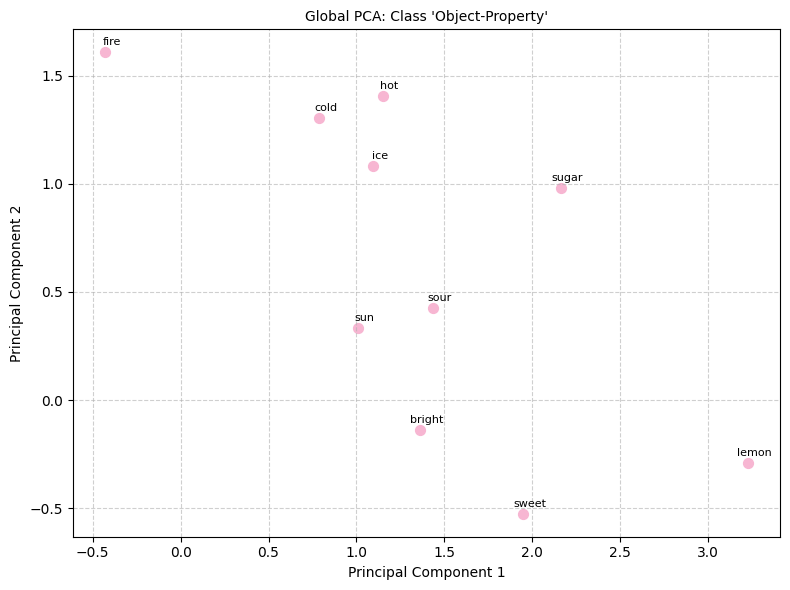

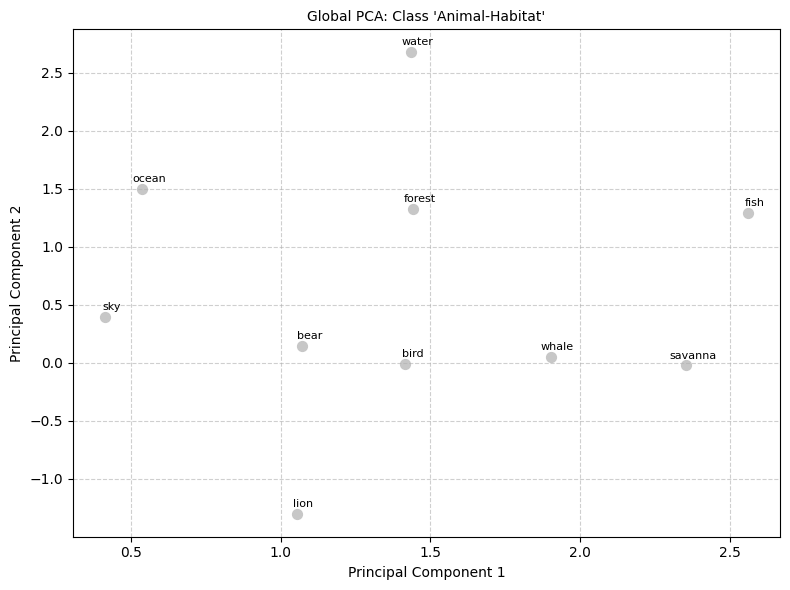

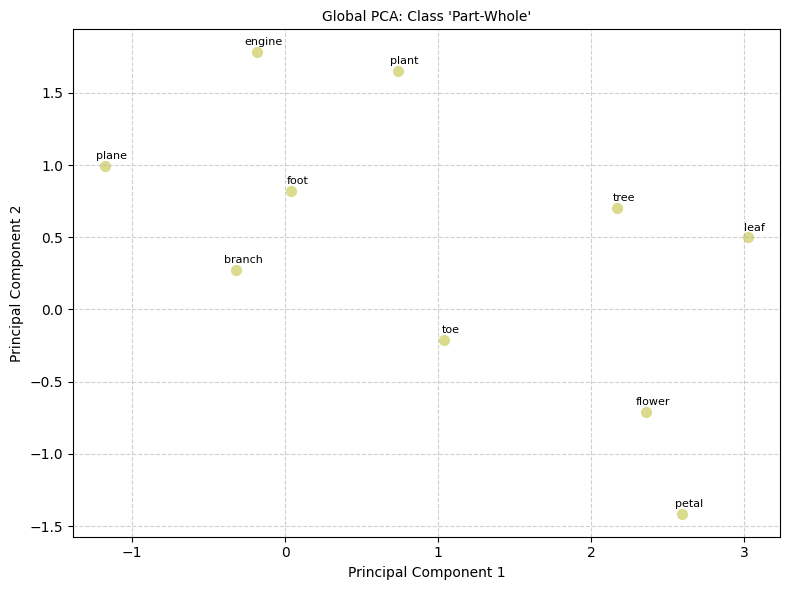

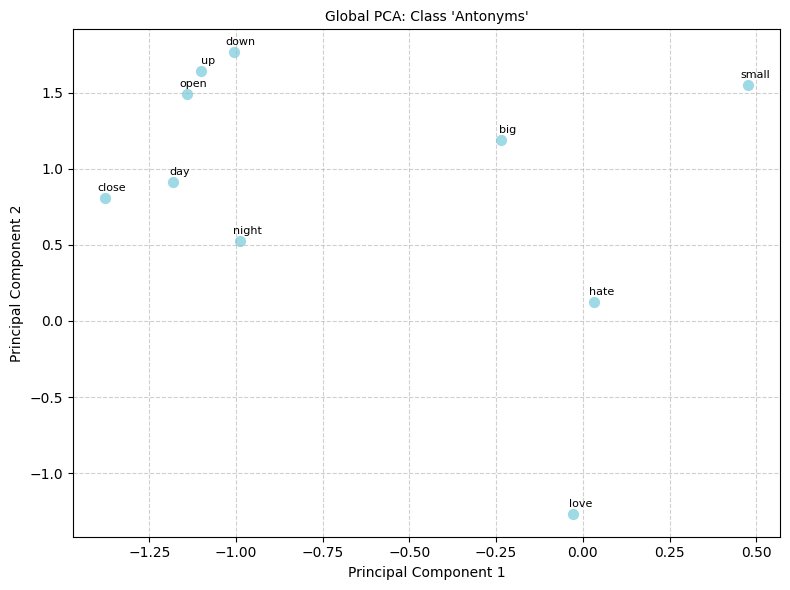


Part 2 (Global PCA plots) complete!


In [9]:
# --- Generate colors for classes for better visualization ---
colors = plt.cm.get_cmap('tab20', len(semantic_classes))
class_colors = {name: colors(i) for i, name in enumerate(semantic_classes.keys())}
word_colors_global = {word: class_colors[word_to_class_map[word]] for word in all_words}


# --- Chart 1: Global PCA of All 100 Words ---
fig_global, ax_global = plt.subplots(figsize=(10, 8))
# Create a mapping from word to its index in all_words list for easy lookup
word_to_idx = {word: i for i, word in enumerate(all_words)}
plot_pca_embeddings(
    ax_global,
    transformed_embeddings_global,
    all_words,
    "Global PCA: All 100 Words",
    color_map=word_colors_global
)
# Add a legend for classes
handles = [plt.Line2D([0], [0], marker='o', color='w', label=cls_name,
                      markerfacecolor=class_colors[cls_name], markersize=10)
           for cls_name in semantic_classes.keys()]
ax_global.legend(handles=handles, title="Semantic Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()


# --- Charts 2-11: Global-Space PCA for Each Class (10 separate charts) ---
print("\nPlotting Global-Space PCA for each class...")
for class_name, pairs in semantic_classes.items():
    class_words = [word for pair in pairs for word in pair]
    # Filter global transformed embeddings for words in the current class
    class_indices = [word_to_idx[word] for word in class_words]
    transformed_class_embeddings = transformed_embeddings_global[class_indices]

    fig, ax = plt.subplots(figsize=(8, 6))
    plot_pca_embeddings(
        ax,
        transformed_class_embeddings,
        class_words,
        f"Global PCA: Class '{class_name}'",
        # Use the specific color for the class
        color_map={word: class_colors[class_name] for word in class_words}
    )
    plt.tight_layout()
    plt.show()

print("\nPart 2 (Global PCA plots) complete!")

# 3. Local PCA plots


Plotting Local-Space PCA for each class...


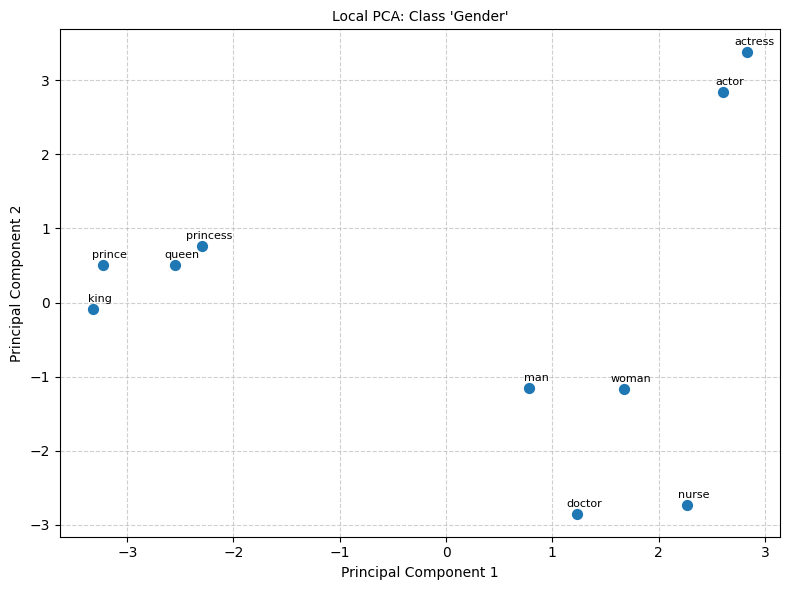

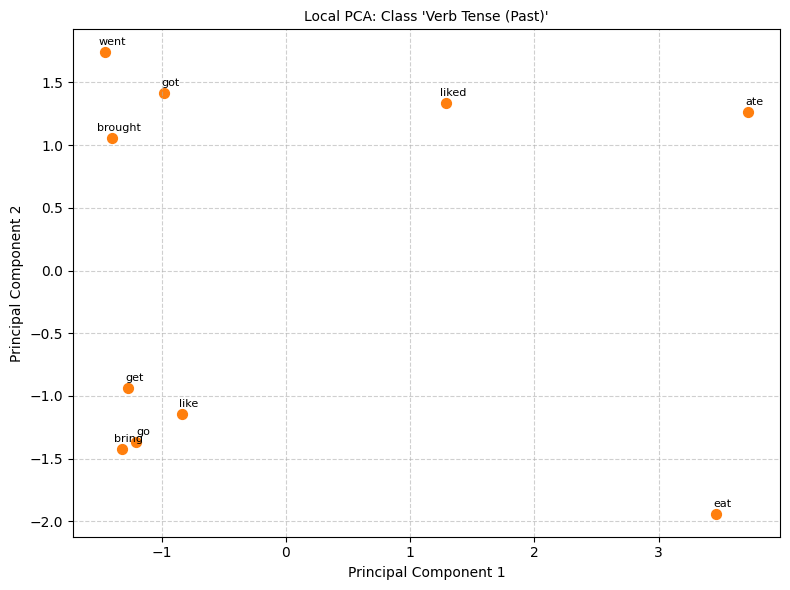

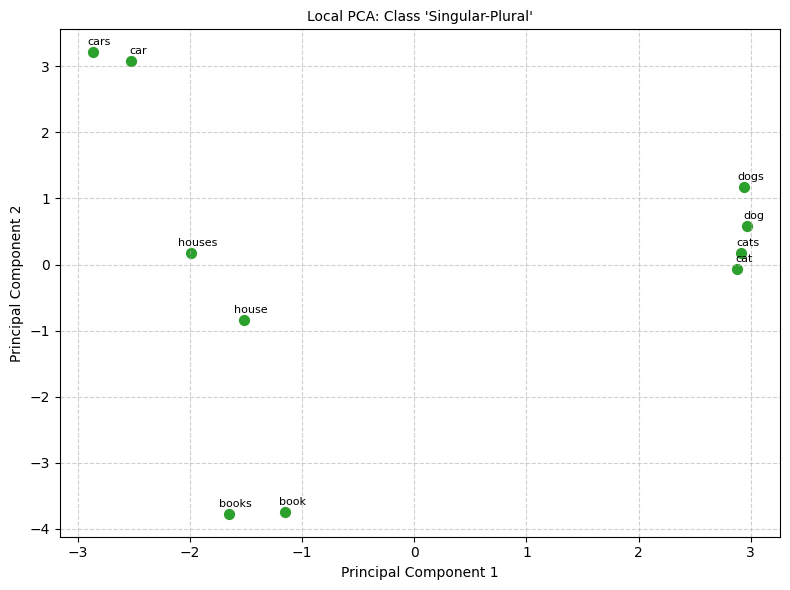

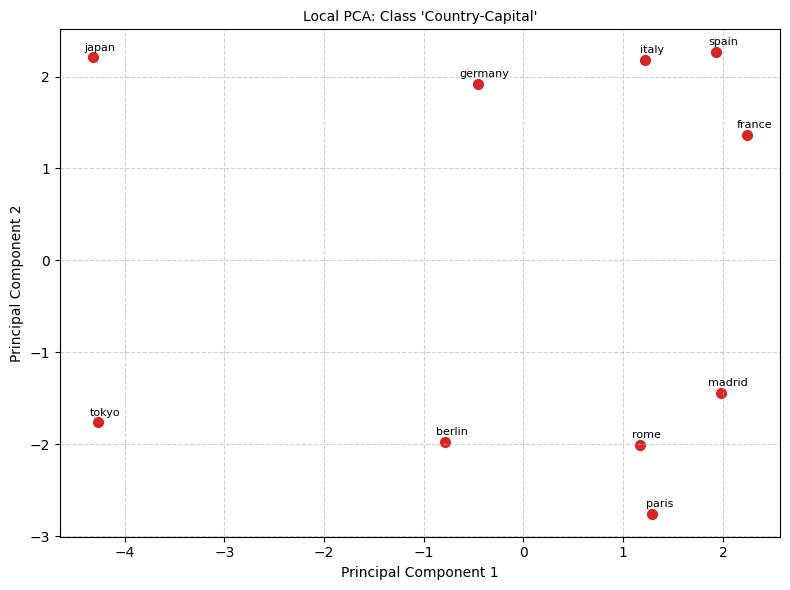

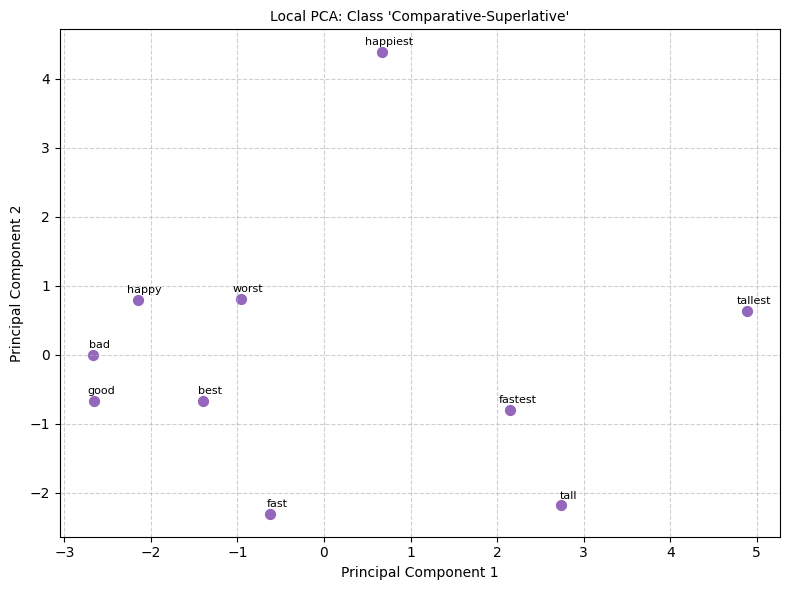

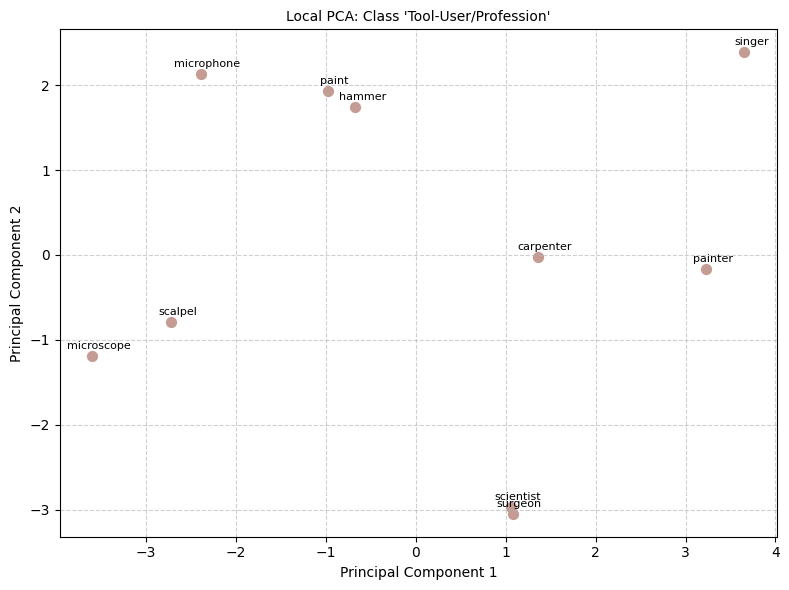

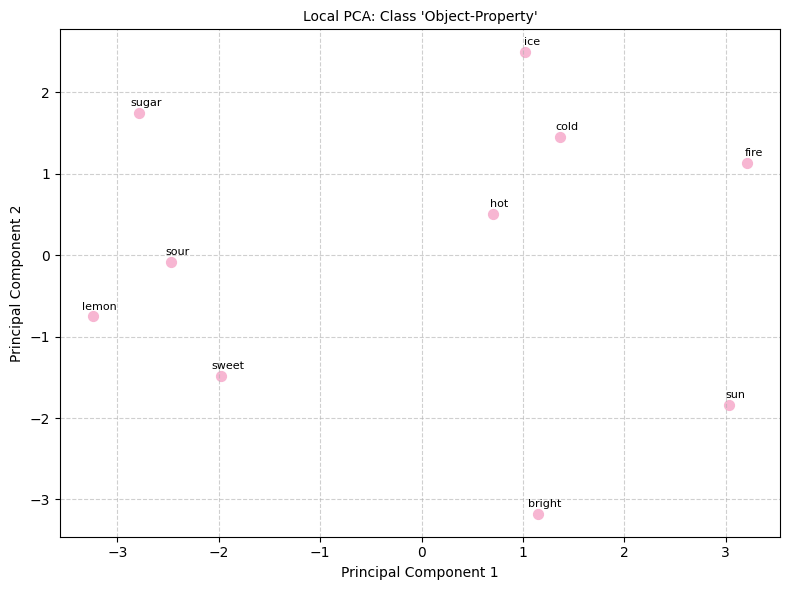

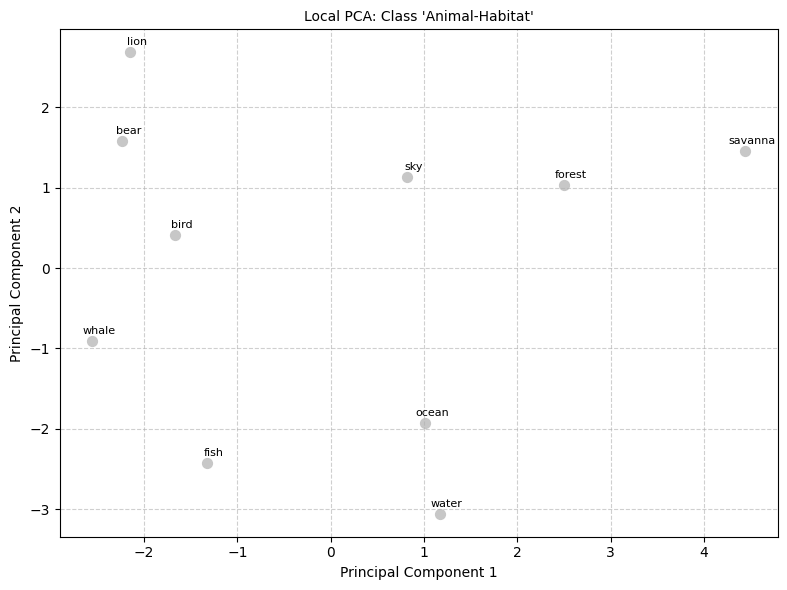

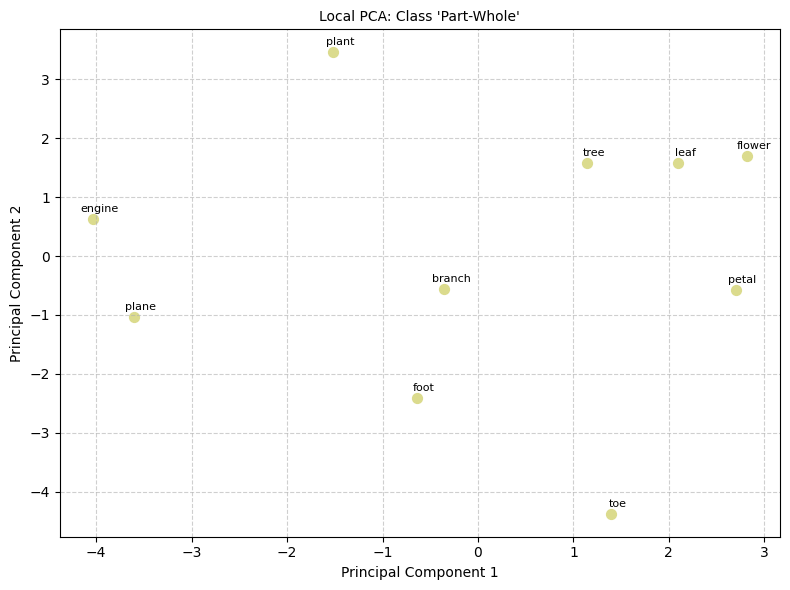

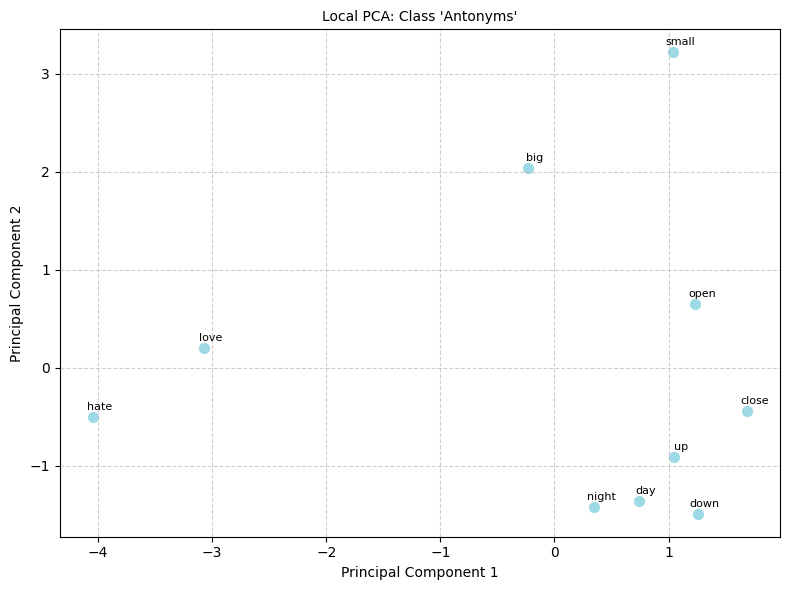


Part 2 (Global PCA plots) complete!


In [10]:
print("\nPlotting Local-Space PCA for each class...")
for class_name, pairs in semantic_classes.items():
    class_words = [word for pair in pairs for word in pair]

    class_embeddings = [get_embedding(word, embedding_model) for word in class_words]

    pca_local = PCA(n_components=2)
    transformed_embeddings_local = pca_local.fit_transform(class_embeddings)

    fig, ax = plt.subplots(figsize=(8, 6))
    plot_pca_embeddings(
        ax,
        transformed_embeddings_local,
        class_words,
        f"Local PCA: Class '{class_name}'",
        # Use the specific color for the class
        color_map={word: class_colors[class_name] for word in class_words}
    )
    plt.tight_layout()
    plt.show()

print("\nPart 3 (Local PCA plots) complete!")